# Imports

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord, angular_separation, get_sun
from astropy.time import Time,TimeMJD
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import math
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
from matplotlib import animation as pan
import time
from IPython.display import display, clear_output
import os
#import plotly # von Leo zum Interaktiven Anzeigen von Grafiken!!
#from matplotlib.backends.backend_pdf import PdfPages

/tmp/ipykernel_907301/2776935530.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part mit Definitionen

In [2]:
## GET SUN POSITION

def sun_pos(times,skyra=278.416201, skydec=-21.061048):
    c = SkyCoord(skyra, skydec, frame='icrs', unit='deg')
    times = Time((times), format='mjd')
    #tmjd = times.mjd
    #t.utc
    near = []
    #sepa=[]
    #sepadeg=[]
    for t in times:
        sunloc = get_sun(t)
        sep = angular_separation(c.ra,c.dec, sunloc.ra,sunloc.dec)
        
        condition = np.rad2deg(sep)<8*u.deg
        #sepa.append(sep)
        #sepadeg.append(np.rad2deg(sep))
        if condition ==True :
            near.append(t.value)
            #if 55554 < np.float64(t.value) < 55570: print(sunloc)
    return near

In [3]:
def undersampling(input_data, spline_bin, fixed_ends: bool = False, mean_ends: bool = False):
    
    new_array = []
    for i in range(0, len(input_data), spline_bin):
        mean = 0
        den = 0
        if ((i+spline_bin-1)<len(input_data)): ##check if you're not at the end of the LC
            
            for j in range(0, spline_bin, 1):
                if (math.isnan(input_data[i+j]) != True):
                    mean += input_data[i+j]
                    den += 1
            if den==0: ## just nan in the spline_bin segments
                new_array.append(0)
            else:
                new_array.append(mean/den)
            
    if fixed_ends:
        for i in range(0,spline_bin,1):
            if (math.isnan(input_data[i]) == False):
                new_array.insert(0, input_data[i])
                break
        
        for i in range(len(input_data)-1,len(input_data)-1-spline_bin,-1):
            if (math.isnan(input_data[i]) == False):
                new_array.insert(len(new_array), input_data[i])
                break
    
    if mean_ends:
        mean = 0
        den = 0
        for i in range(0,spline_bin//2,1):
            if (math.isnan(input_data[i]) != True):
                mean += input_data[i]
                den += 1
        if den==0: ## just nan in the spline_bin segments
            new_array.insert(0,0)
        else:
            new_array.insert(0,mean/den)
        mean = 0
        den = 0        
        for i in range(len(input_data)-1,len(input_data)-1-spline_bin//2-len(input_data)%spline_bin,-1):
            if (math.isnan(input_data[i]) != True):
                mean += input_data[i]
                den += 1
        if den==0: ## just nan in the spline_bin segments
            new_array.insert(len(new_array),0)
        else:
            new_array.insert(len(new_array),mean/den)
    
    return np.array(new_array)

In [4]:
def my_sin(x, amplitude, phase, offset, period:float=2.2):
        return np.sin(x * ((2 * np.pi) / (period * 365.25)) + phase) * amplitude + offset

Periode von Sara hat eigentlich auch einen Fehler!!

# Parameters

- source coordinates
- path_lc
- time interval (From, To)
- scaling power?
- flux or flux_fixed?
- spline_bin!!!
- edges yes or no?

In [5]:
def detr_amplitude(spline_bin: int = 15, path_lc: str = "/home/praktikum/kfischer/auswertung/PG1555/2_4fgl_j1555.7+1111_lightcurve.npy",
                   FROM: float = 54680, TO: float = 60230, scaling_power: int = 8, period_time: float = 2.2,
                   skyra_source: float = 238.929350, skydec_source: float = 11.190101, 
                   TAKEflux_fixed: bool = True, fixed_ends: bool = False, mean_ends: bool = False,
                   path_fig: str = "/home/praktikum/kfischer/auswertung/PG1555/splines/",
                   savefigs: bool = True, cut_edge: bool = True):
    #####  CHECK IF PATHS EXIST OTHERWISE CREATE THEM  #####

    if not os.path.exists(path_lc):
        os.makedirs(path_lc)
        print(f"The new directory {path_lc} is created!")

    if not os.path.exists(path_fig):
        os.makedirs(path_fig)
        print(f"The new directory {path_fig} is created!")
    
    
    ##### DATA IMPORT ######
    
    data_lc = np.load(path_lc, allow_pickle=True,encoding='latin1')
    df_fixed = pd.DataFrame({k: data_lc.tolist()[k] for k in (
        'tmin_mjd', 'tmax_mjd', 'flux_fixed', 'flux_err_fixed', 'ts', 'flux_ul95', 'fit_quality', 'fit_success')})
    df = pd.DataFrame({k: data_lc.tolist()[k] for k in (
        'tmin_mjd', 'tmax_mjd', 'flux', 'flux_err', 'ts', 'flux_ul95', 'fit_quality', 'fit_success')})
       
    ## SELECT QUALITY ##
    
    df_fixed = df_fixed.where((df_fixed['fit_quality'] == 3) & (df_fixed['fit_success'] == True))
    df = df.where((df['fit_quality'] == 3) & (df['fit_success'] == True))
    
    ##########################################
    ##########################################
    ###########    FILTERS    ################
    ##########################################
    ##########################################
    ###  ---> pd.Dataframe.where ersetzt values mit nan, wenn die Bedingung nicht zutrifft
    
    ###### SELECT TIME RANGE ######
       
    df_fixed = df_fixed[df_fixed['tmin_mjd'].between(FROM,TO)].reset_index(drop=True)
    df = df[df['tmin_mjd'].between(FROM,TO)].reset_index(drop=True)
    
    #file_name_results = './results_data/results_file_' + str(FROM) + '_' + str(TO) + '_10k.txt'
    
    ###### REMOVE POINTS WITH ERROR/FLUX > 100% and TS<1 ######
    
    df_fixed['flux_fixed'] = df_fixed['flux_fixed'].where(
        (df_fixed['flux_err_fixed']<df_fixed['flux_fixed'])&(df_fixed['ts']>1)
        )
    df['flux'] = df['flux'].where(
        (df['flux_err']<df['flux'])&(df['ts']>1)
        )
    df_fixed['flux_err_fixed'] = df_fixed['flux_err_fixed'].where(
        (df_fixed['flux_err_fixed']<df_fixed['flux_fixed'])&(df_fixed['ts']>1)
        )
    df['flux_err'] = df['flux_err'].where(
        (df['flux_err']<df['flux'])&(df['ts']>1)
        )
        
    ###### SUN FILTER ######
    time_sun = sun_pos(df['tmin_mjd'].values, skyra= skyra_source, skydec= skydec_source)
    #print(time_sun)
    for i in range (0, len(time_sun)):
        df['flux'] = df['flux'].where(df['tmin_mjd'] != time_sun[i])
        df['flux_err'] = df['flux_err'].where(df['tmin_mjd'] != time_sun[i])
    for i in range (0, len(time_sun)):
        df_fixed['flux_fixed'] = df_fixed['flux_fixed'].where(df_fixed['tmin_mjd'] != time_sun[i])
        df_fixed['flux_err_fixed'] = df_fixed['flux_err_fixed'].where(df_fixed['tmin_mjd'] != time_sun[i])
    
    ####################################################################################
    ####################################################################################
    ####################################################################################
    ####################################################################################
        
    ## TAKE TIME, FLUX AND FLUX_ERR ##
        
    time_fixed = df_fixed['tmin_mjd'].values #(df_fixed['tmin_mjd'].values + df_fixed['tmax_mjd'].values) / 2
    flux_fixed = df_fixed['flux_fixed'].values * 10**scaling_power
    flux_err_fixed = df_fixed['flux_err_fixed'].values * 10**scaling_power
    
    time = df['tmin_mjd'].values #(df['tmin_mjd'].values + df['tmax_mjd'].values) / 2
    flux = df['flux'].values * 10**scaling_power
    flux_err = df['flux_err'].values * 10**scaling_power
    
    ####################################################################################
    ####################################################################################

    #### CHOOSE BETWEEN FLUX AND FLUX_FIXED #######

    if TAKEflux_fixed:
        time = time_fixed
        flux = flux_fixed
        flux_err = flux_err_fixed
    else:
        time
        flux
        flux_err
    
    ##############################
    ########  SPLINE  ############
    ##############################
    
    if fixed_ends:
        under_sample_flux = undersampling(flux, spline_bin, fixed_ends)
        under_sample_time = undersampling(time, spline_bin, fixed_ends)
    elif mean_ends:
        under_sample_flux = undersampling(flux, spline_bin, fixed_ends=False, mean_ends=True)
        under_sample_time = undersampling(time, spline_bin, fixed_ends=True, mean_ends=False)
    else:
        under_sample_flux = undersampling(flux, spline_bin, fixed_ends, mean_ends)
        under_sample_time = undersampling(time, spline_bin, fixed_ends, mean_ends)
        
    spline = CubicSpline(under_sample_time, under_sample_flux)
    flux_norm = flux - spline(time)

    detr_data_df = pd.DataFrame(data={'time':time, 'detr_flux':flux_norm})

    ####################################################################################
    ########  AMPLITUDE FIT  ###########################################################
    ####################################################################################

    #### CUT EDGES FROM DATA  ####
    ####  NACH SARA HALBES SPLINE_BINNING  #####
    
    if cut_edge:
        reduce = round(spline_bin/2.0) # 15//2 = 7 statt 7.5

        flux_red = flux_norm[reduce:-reduce] ## cut the outer {reduce} points from the data to fit
        flux_err_red = flux_err[reduce:-reduce]
        time_red = time[reduce:-reduce]
    else:
        reduce = 0
        flux_red = flux_norm
        flux_err_red = flux_err
        time_red = time
    
    ####  CHECK DATA (NAN OR INF)  ####
    
    time_red1 = []
    flux_red1 = []
    flux_err_red1 = []
    for i in range(len(flux_red)):
        if not math.isnan(flux_red[i]):
            time_red1.append(time_red[i])
            flux_red1.append(flux_red[i])
            flux_err_red1.append(flux_err_red[i])
    time_red = time_red1
    flux_red = flux_red1
    flux_err_red = flux_err_red1
    
    
    #fix_freq = 2 *np.pi/ (period_time * 365.25)
    guess_period = period_time
    guess_amplitude = 3*np.std(flux_red)/(2**0.5)
    guess_phase = 2.57037649 #np.pi
    guess_offset = np.mean(flux_red)    
    
    p0=[guess_amplitude, guess_phase, guess_offset, guess_period]
    
    
    
    popt, pcov = curve_fit(lambda x, a, ph, off, p_time: my_sin(x,amplitude=a,phase=ph,offset=off,period=p_time), 
                    time_red, flux_red,p0=p0, sigma=flux_err_red, maxfev=5000) #, absolute_sigma=True) pcov wird bei True nicht hoch skaliert
    perr= np.sqrt(np.diag(pcov))
    # Amplitude, Phase, Offset, Period
    
    #data_first_guess = my_sin(time, *p0, period=period_time)
    data_fit = my_sin(time, *popt)
    data_fit_perr = my_sin(time, popt[0]+perr[0], popt[1], popt[2],popt[3])
    data_fit_merr = my_sin(time, popt[0]-perr[0], popt[1], popt[2],popt[3])

    fit_params = popt
    amplitude = fit_params[0]
    period_opt = fit_params[3]

    ####################################################################################
    #########  CHI-SQUARED  ############################################################
    ####################################################################################
    
    summe = 0
    for i in range(len(flux_red)):
        summe += ((data_fit[reduce+i]-flux_red[i])/flux_err_red[i])**2 #Chisq aus curve_fit function (see documentation)
        #summe += ((data_fit[reduce+i]-flux_red[i])**2/data_fit[reduce+i])  # Definition von Chi Squared sigma**2 = haeufigkeit
    
    chi = summe
    chi_red = chi/(len(flux_red)-3.0)
    
    #print(f"{chi_red:.2f}")
    
    ####################################################################################
    #########  MEAN FLUX  ############################################################
    ####################################################################################
    
    #f_mean = np.mean(flux_red + spline(time_red))
    
    weight = np.power(flux_err_red,-2)
    f_mean = np.average(flux_red + spline(time_red),weights=weight)
    f_mean_err = np.sqrt(1/np.sum(weight))
    
    ####################################################################################
    #########  SAVE FIGURES FOR EVALUATION  ############################################
    ####################################################################################

    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
    fig.suptitle(f"Spline binning of {spline_bin} (x28) days \n Chi_red = {chi_red:.2f} \n {period_opt = :.2f} +- {perr[3]:.2f}")
    ax1.errorbar(time, flux, yerr=flux_err, fmt=' ', marker='.', color='darkblue')
    xx = np.linspace(min(time), max(time), 10000)
    ax1.plot(xx, spline(xx), color='tab:orange', label='Spline '+str(spline_bin)+' (x28) days bin')
    ax1.scatter(under_sample_time, under_sample_flux, marker='o', linewidth=1.5, color='orange')
    ax1.tick_params(axis='both', labelsize=13)
    ax1.set(xlabel='MJD',ylabel=r'Flux [$\times 10^{-%i}$ cm$^{-2}$ s$^{-1}$]' % scaling_power)
    #ax1.xlabel('MJD', fontsize=15)
    #ax1.ylabel(r'Flux [$\times 10^{-%i}$ cm$^{-2}$ s$^{-1}$]' % scaling_power, fontsize=15)
    ax1.grid(linewidth=0.6)
    ax1.legend(fontsize=13, loc='upper left')
    for i in range(0, len(time_sun)):
        if i==0:
            ax1.axvline(x=time_sun[i], color='yellow', alpha=0.3, label='Sun cut')
        ax1.axvline(x=time_sun[i], color='yellow', alpha=0.3)
    #ax1.savefig('lc.pdf', format='pdf', dpi=1000)
    
    #fig, ax = plt.subplots(figsize=(6,4))
    ax2.plot(time, data_fit, color='r', label='Sine Fit')
    ax2.plot(time, data_fit_merr, label='Minimal Sine Fit')
    ax2.plot(time, data_fit_perr, label='Maximal Sine Fit')
    ax2.fill_between(time, data_fit_perr, data_fit_merr, alpha=.25, label='1-sigma amplitude interval')
    ax2.errorbar(time,flux_norm,yerr=flux_err,fmt='k+-',ecolor='b',label='Normalized flux with '+str(spline_bin)+' (x56) days bin')
    ax2.set(xlabel='MJD',ylabel=r'Photon Flux [$\times 10^{-%i}$ cm$^{-2}$ s$^{-1}$]' % scaling_power)
    #ax2.set_ylabel(r'Photon flux [$\times 10^{-8} s^{-%x} cm^{-2}$]'% scaling_power)
    #ax2.set_xlabel('MJD')
    ax2.grid(linewidth=0.6)
    ax2.legend(loc='upper left')
    #ax2.set_ylim([-3, 6])
    for i in range(0, len(time)):
        if i<reduce or i >= len(time)-reduce:
            if i == 0:
                ax2.axvline(x=time[i], color='orange', alpha=0.6, label='Sine fit cut')
            else:
                ax2.axvline(x=time[i], color='orange', alpha=0.6)

    '''
    existing_pdf_path = path_fig+'spline_'+str(1)+'.pdf'
    with PdfPages(existing_pdf_path,'a') as pdf:
        pdf.savefig()  # Saves the current figure into a pdf page
        plt.close()
    '''
    
    if savefigs:
        fig.savefig(path_fig+'spline_'+str(spline_bin)+'.png',format='png',dpi=300) # kleiner pdf, und noch kleiner eps
    plt.close()
    #del(fig)
    ####################################################################################
    ####################################################################################
    
    return (amplitude,perr[0], chi_red, f_mean, f_mean_err, period_opt, perr[3])#fig)

## Interessanter Fitter mit der Moeglichkeit, Variablen zu fixen

# Analyse von allen 5 Quellen

In [13]:
quellen = ['PG_1553', 'OJ_014', 'PKS_0454', 'PKS_2155', 'S5_0716']

lists_path_lcs = ['LCs_Kilian/1_4fgl_j1555.7+1111_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j0811.4+0146_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j0457.0-2324_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j2158.8-3013_lightcurve.npy',
                  'LCs_Kilian/1_4fgl_j0721.9+7120_lightcurve.npy']

# lists_path_lcs = ['LCs_Sara/fullTime_4fgl_j1555.7+1111_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j0811.4+0146_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j0457.0-2324_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j2158.8-3013_lightcurve.npy',
#                   'LCs_Sara/fullTime_4fgl_j0721.9+7120_lightcurve.npy']

# Coordinates from Saras Tabelle
lists_skyra_source = [238.93169, 122.86418, 74.26096, 329.71409, 110.48882]
lists_skydec_source = [11.18768, 1.77344, -23.41384, -30.22556, 71.34127]
lists_period_glsp = [2.1, 4.1, 3.5, 1.7, 2.6]
lists_period_glsp_err = [0.2, .4, .4, .1, .4]

lists_period_time_sara = [2.2, 4.1, 3.6, 1.7, 2.7]
lists_period_time_penil = [2.2, 4.3, 2.6, 1.7, 2.8]

list_pos = [29, 39,24,21,24]

input_dict = dict()
for i in range(5):
    input_dict[quellen[i]] = [lists_path_lcs[i], lists_skyra_source[i], lists_skydec_source[i], 
                              lists_period_time_sara[i], lists_period_time_penil[i], 
                              lists_period_glsp[i], lists_period_glsp_err[i], list_pos[i]]
# input_dict = {'PG_1553', 
#               'OJ_014', 
#               'PKS_0454', 
#               'PKS_2155', 
#               'S5_0716'}

In [7]:
standard_path = '/home/praktikum/kfischer/auswertung/'

## Amplituden fit fuer alle 5 Quellen mit Vergleich uncut mean

Next step would be to divide the big cell into smaller ones and making it more modular (idea is to only compute the detr_amplitude once)

##########
Quelle: PG_1553
10: 	2.2329
11: 	2.2515
12: 	2.2087
13: 	2.2861
14: 	2.2141
15: 	2.3885
16: 	2.5718
17: 	2.4333
18: 	2.4550
19: 	2.4416
20: 	2.4528
21: 	2.3540
22: 	2.3240
23: 	2.2513
24: 	2.2272
25: 	2.2278
26: 	2.2361
27: 	2.2098
28: 	2.1871
29: 	2.1695
30: 	2.2779
31: 	2.2421
32: 	2.2182
33: 	2.1942
34: 	2.1872
35: 	2.3870
36: 	2.3420
37: 	2.3356
38: 	2.3527
39: 	2.3103
40: 	2.3198
41: 	2.2743
42: 	2.3149
43: 	2.3705
44: 	2.4244
45: 	2.3668
46: 	2.3273
47: 	2.3851
48: 	2.3265
49: 	2.2964
50: 	2.3241
51: 	2.3255
52: 	2.3724
53: 	2.3606
54: 	2.3272
55: 	2.3050
56: 	2.3057
57: 	2.3045
58: 	2.3195
59: 	2.3563
60: 	2.3604
61: 	2.3634
62: 	2.3622
63: 	2.3561
64: 	2.3401
65: 	2.3369
66: 	2.3614
67: 	2.3999
68: 	2.4081
69: 	2.4865
70: 	2.4830
71: 	2.4746
72: 	2.4753
73: 	2.4785
74: 	2.4997
75: 	2.5196
76: 	2.5194
77: 	2.5204
78: 	2.5122
79: 	2.4929
10 _v2: 	2.2741
11 _v2: 	2.5578
12 _v2: 	2.2583
13 _v2: 	2.6226
14 _v2: 	2.6622
15 _v2: 	2.5545
16 _v2: 	2.5243
17 _v2: 	2.5767
18 _v

10: 	37.2383
11: 	35.9386
12: 	38.1471
13: 	37.8220
14: 	38.8959
15: 	40.1693
16: 	43.4293
17: 	42.7466
18: 	43.1840
19: 	40.9017
20: 	42.3310
21: 	49.2289
22: 	54.1481
23: 	52.6098
24: 	48.8012
25: 	48.8994
26: 	53.3689
27: 	52.6100
28: 	51.0215
29: 	49.3139
30: 	50.8758
31: 	52.1543
32: 	52.7357
33: 	54.1543
34: 	54.7436
35: 	53.7230
36: 	54.2403
37: 	54.4916
38: 	53.4202
39: 	52.5206
40: 	52.0221
41: 	55.7666
42: 	53.5941
43: 	54.3031
44: 	55.3027
45: 	56.6610
46: 	57.3966
47: 	57.9081
48: 	59.1266
49: 	59.1966
50: 	59.1256
51: 	55.9011
52: 	54.5391
53: 	53.3652
54: 	53.3028
55: 	53.6999
56: 	53.7897
57: 	53.8799
58: 	54.1475
59: 	54.5616
60: 	54.6166
61: 	54.5852
62: 	55.6783
63: 	57.0433
64: 	58.2362
65: 	59.2377
66: 	60.6983
67: 	59.6401
68: 	59.7901
69: 	59.6251
70: 	60.1407
71: 	61.0380
72: 	61.1969
73: 	61.2731
74: 	62.2991
75: 	62.8323
76: 	62.9138
77: 	62.8718
78: 	62.1813
79: 	63.0429
10 _v2: 	36.0674
11 _v2: 	34.7136
12 _v2: 	36.9579
13 _v2: 	36.8485
14 _v2: 	38.0062
15 _v

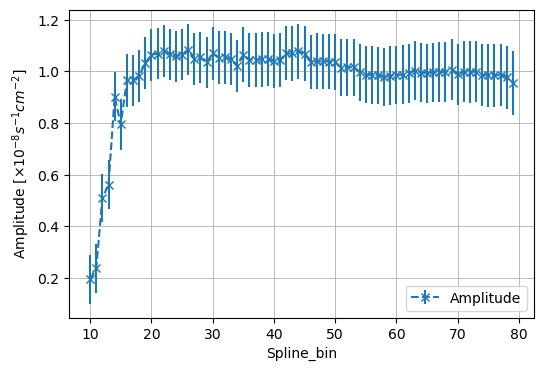

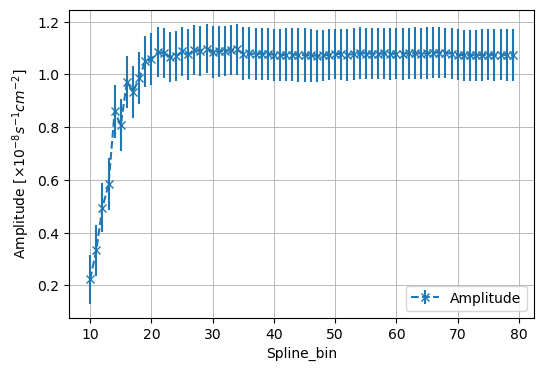

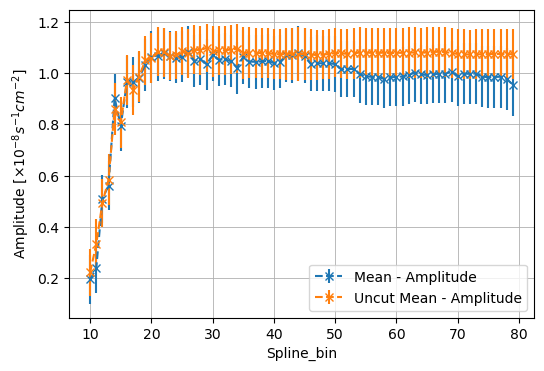

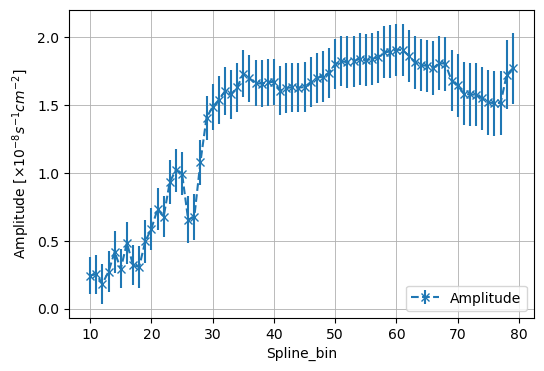

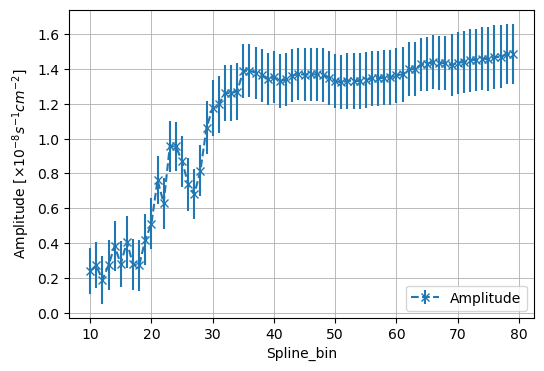

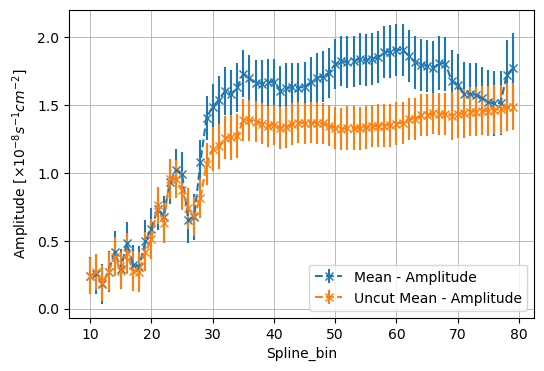

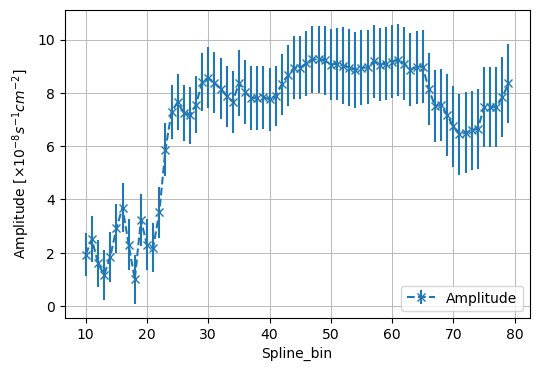

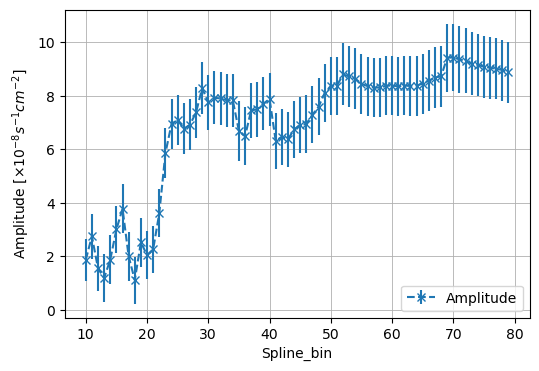

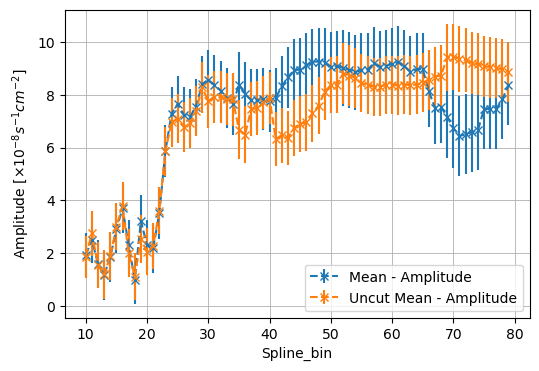

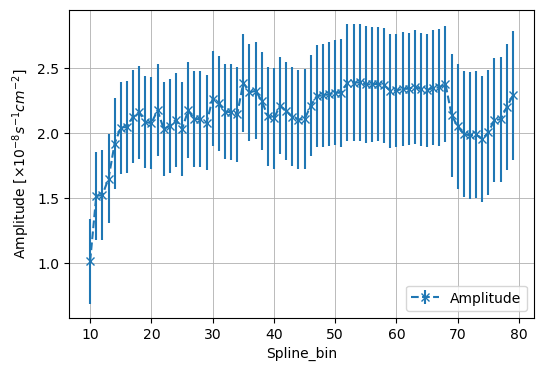

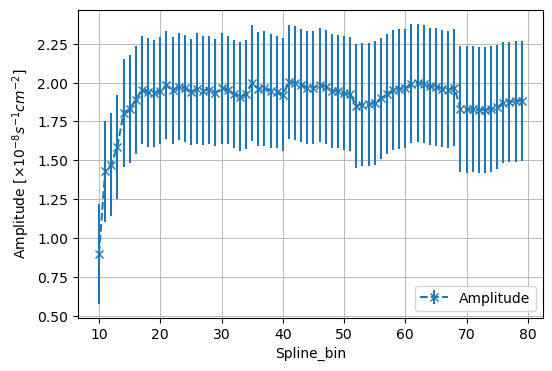

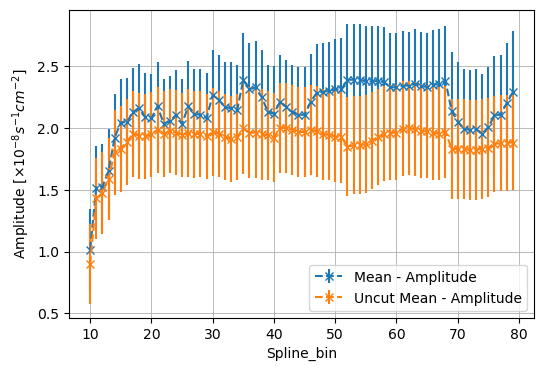

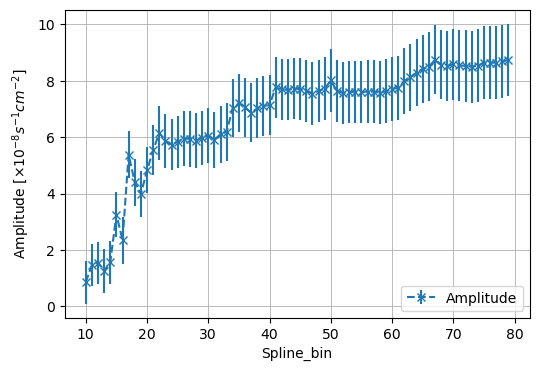

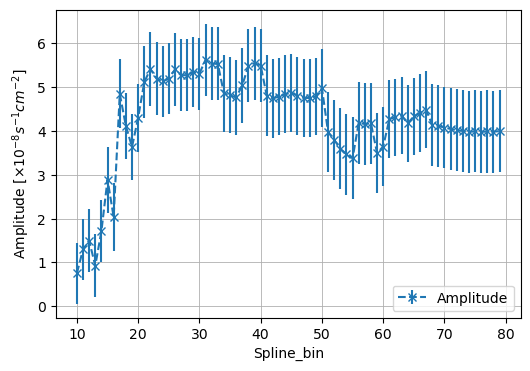

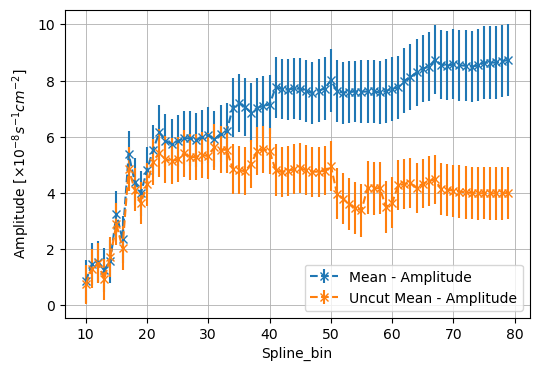

In [8]:
data_out ={}
for i in [0,1,2,3,4]:
    output = [[],[],[],[],[],[],[],[]]
    output_v2 = [[],[],[],[],[],[],[],[]]
    print('#'*10)
    print(f"Quelle: {quellen[i]}")
    for binning in range(10,80,1):
        amp, amp_err, chi_r, f_mean, f_mean_err, per, per_err = detr_amplitude(spline_bin=binning, fixed_ends=False, mean_ends=True, 
                                      path_fig=standard_path+quellen[i]+'/splines_mean-ends_free-Period/',
                                      path_lc=standard_path+lists_path_lcs[i], 
                                      TAKEflux_fixed = True, FROM=0, TO=70000, 
                                      period_time=lists_period_time_sara[i])
        output[0].append(binning)
        output[1].append(amp)
        output[2].append(amp_err)
        output[3].append(chi_r)
        output[4].append(f_mean)
        output[5].append(f_mean_err)
        output[6].append(per)
        output[7].append(per_err)
        print(f"{binning}: \t{chi_r:.4f}")
        
    scaling_power = 8
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.errorbar(output[0], list(map(abs, output[1])),yerr=output[2],marker = 'x', linestyle = '--', label='Amplitude')
    ax.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax.set_xlabel('Spline_bin')
    ax.legend(loc='lower right')
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+quellen[i]+'/splines_mean-ends_free-Period/amplitude_evolution.png',format='png',dpi=300)
    
    for binning in range(10,80,1):
        amp, amp_err, chi_r, f_mean, f_mean_err, per, per_err = detr_amplitude(spline_bin=binning, fixed_ends=False, mean_ends=True, cut_edge = False,
                                      path_fig=standard_path+quellen[i]+'/splines_mean-ends-v2_free-Period/',
                                      path_lc=standard_path+lists_path_lcs[i], 
                                      TAKEflux_fixed = True, FROM=0, TO=70000, 
                                      period_time=lists_period_time_sara[i])
        output_v2[0].append(binning)
        output_v2[1].append(amp)
        output_v2[2].append(amp_err)
        output_v2[3].append(chi_r)
        output_v2[4].append(f_mean)
        output_v2[5].append(f_mean_err)
        output_v2[6].append(per)
        output_v2[7].append(per_err)
        print(f"{binning} _v2: \t{chi_r:.4f}")

    data_out[quellen[i]]=[output,output_v2]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.errorbar(output_v2[0], list(map(abs, output_v2[1])),yerr=output_v2[2],marker = 'x', linestyle = '--', label='Amplitude')
    ax.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax.set_xlabel('Spline_bin')
    ax.legend(loc='lower right')
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+quellen[i]+'/splines_mean-ends-v2_free-Period/amplitude_evolution.png',format='png',dpi=300)
    
    fig, ax = plt.subplots(figsize=(6,4))
    #ax.errorbar(output[0], output[1],yerr=output[2],marker = 'x', linestyle = '--', label='Fixed - Amplitude')
    ax.errorbar(output[0], list(map(abs, output[1])), yerr=output[2], marker = 'x', linestyle = '--', 
                label='Mean - Amplitude')
    ax.errorbar(output_v2[0], list(map(abs, output_v2[1])), yerr=output_v2[2],marker = 'x', linestyle = '--', 
                label='Uncut Mean - Amplitude')
    ax.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax.set_xlabel('Spline_bin')
    ax.legend(loc='lower right')
    ax.grid(linewidth=0.6)
    fig.savefig(standard_path+quellen[i]+'/amplitude_evolution_free-Period.png',format='png',dpi=300)

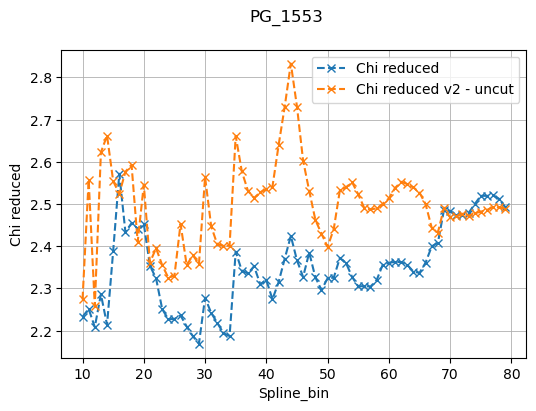

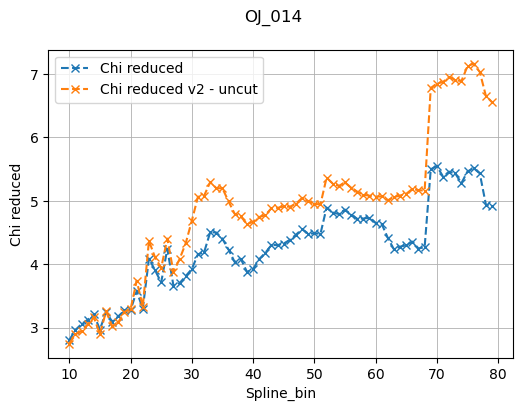

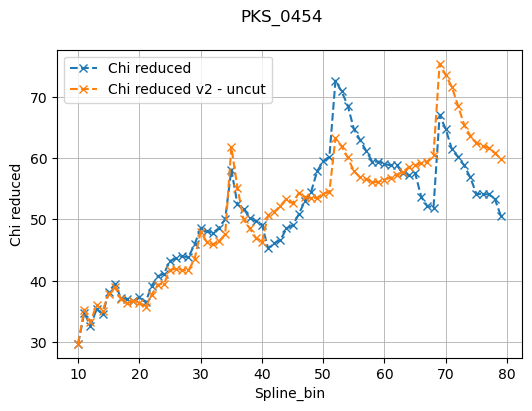

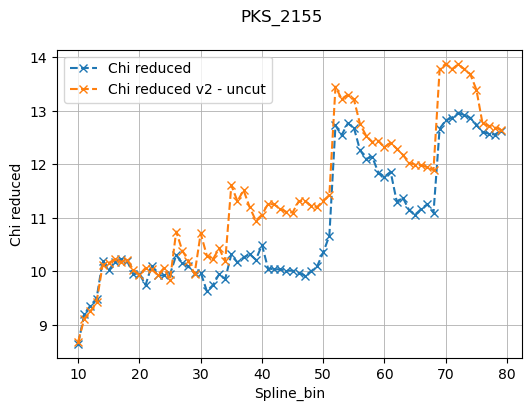

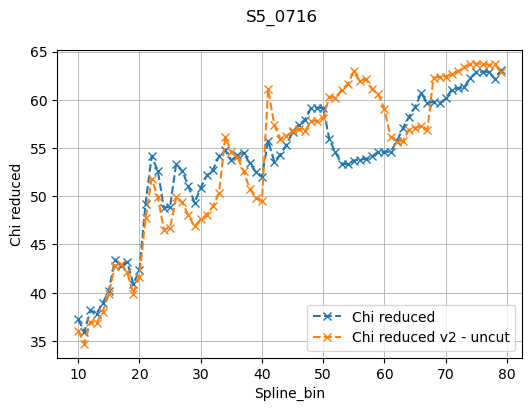

In [9]:
chired = []
chired_v2 = []
for k in data_out.keys():
    chired.append(data_out[k][0][3])
    chired_v2.append(data_out[k][1][3])
    fig, ax = plt.subplots(figsize=(6,4))
    fig.suptitle(k)
    ax.plot(data_out[k][0][0], data_out[k][0][3], 'x--', label='Chi reduced')
    ax.plot(data_out[k][1][0], data_out[k][1][3], 'x--', label='Chi reduced v2 - uncut')
    ax.set_ylabel('Chi reduced')
    ax.set_xlabel('Spline_bin')
    ax.legend()
    ax.grid(linewidth=0.6)
    #fig.savefig(standard_path+k+'/chi_reduced_free-Period.png',format='png',dpi=300)

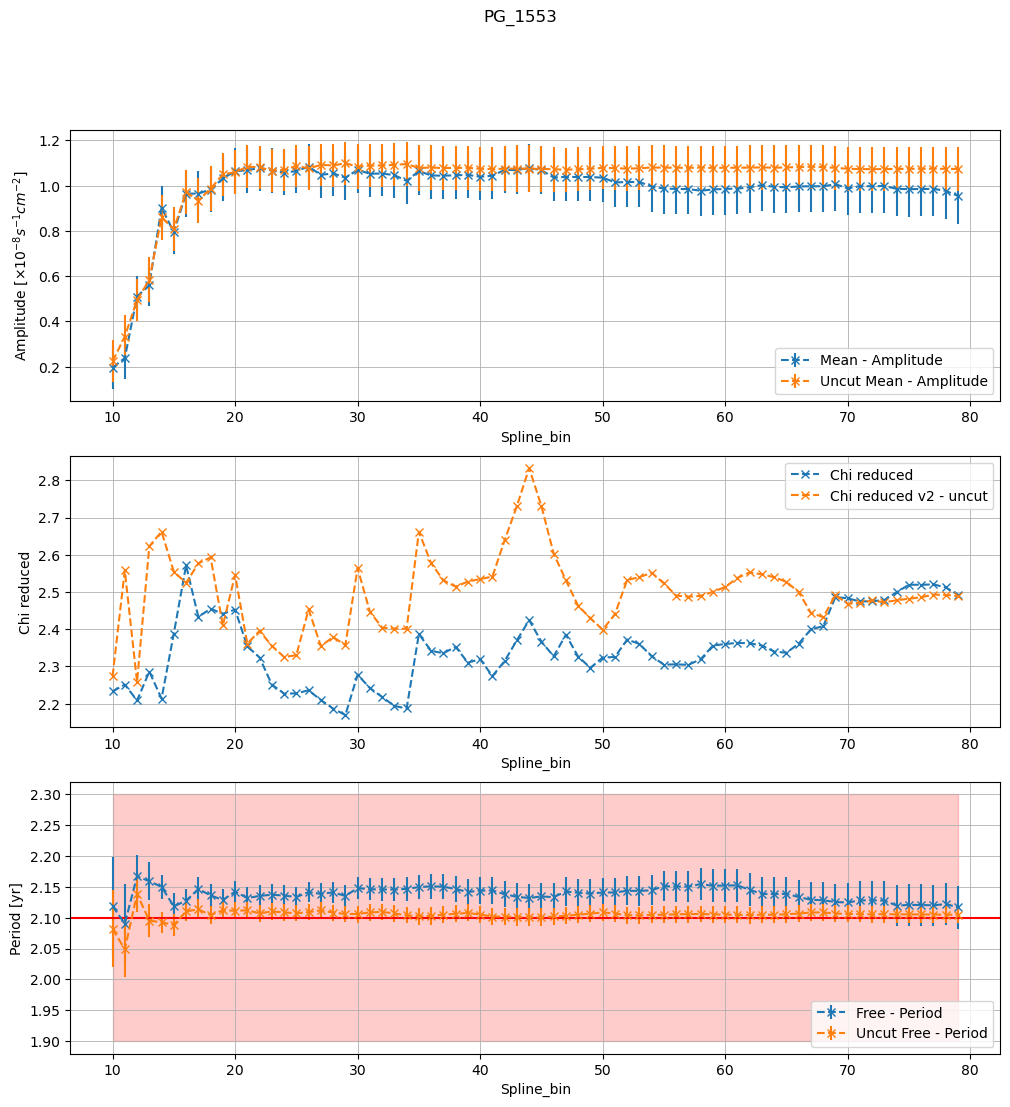

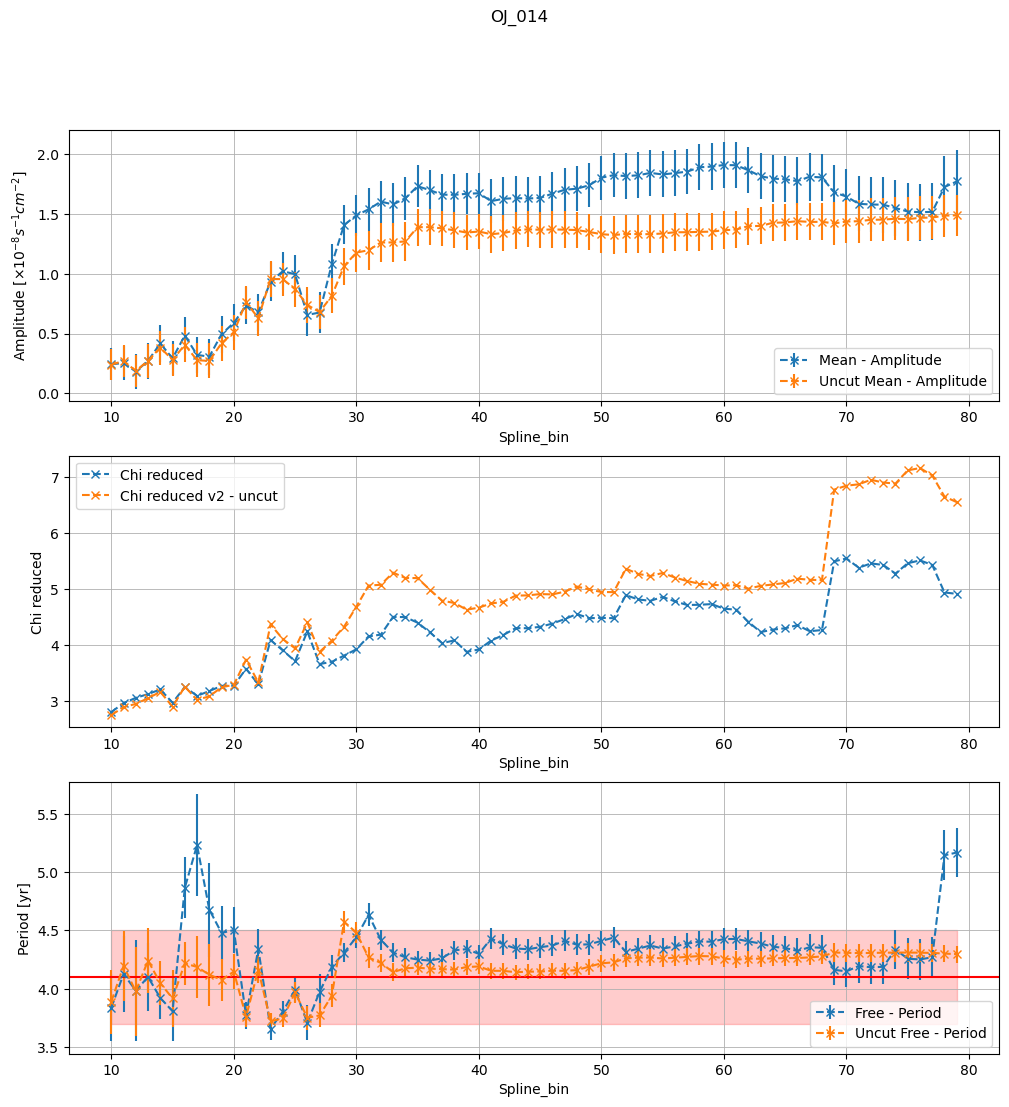

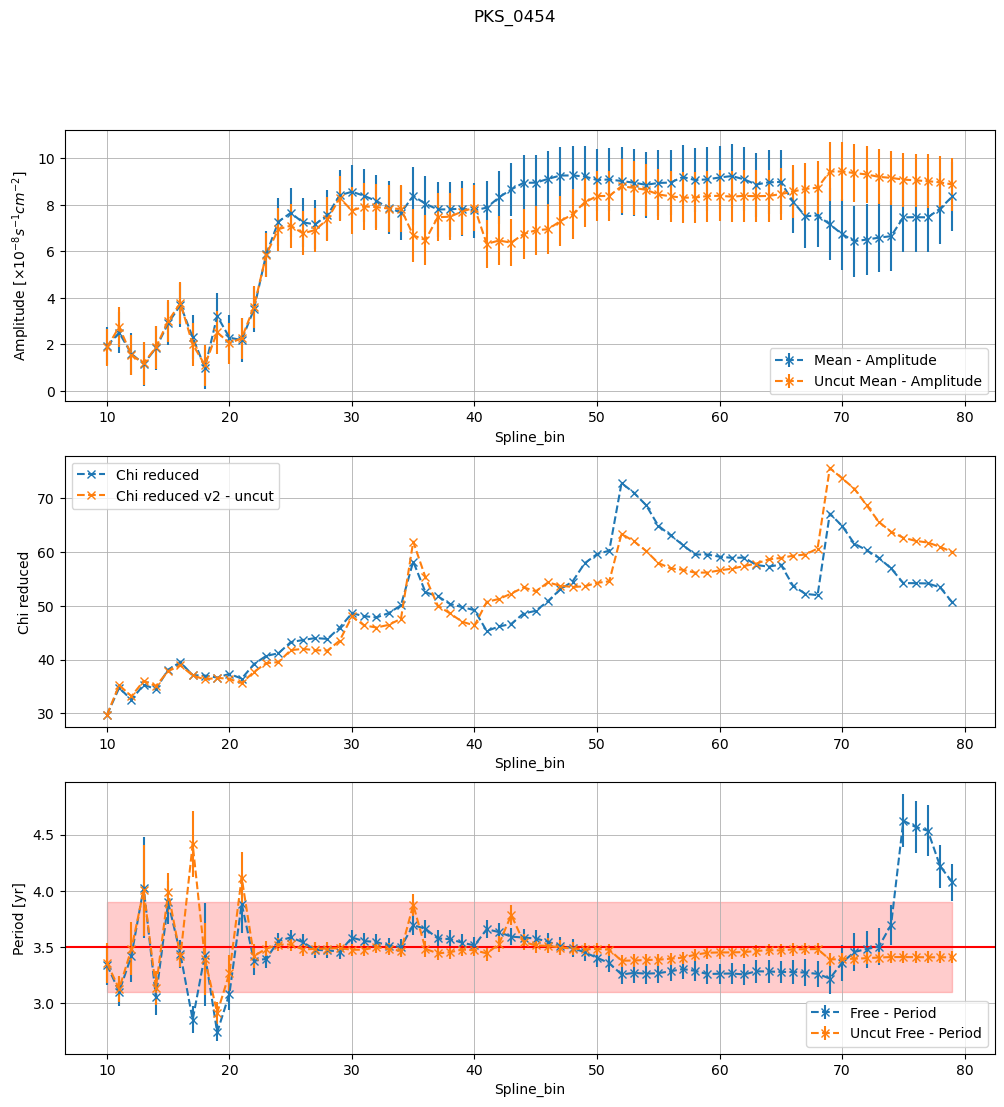

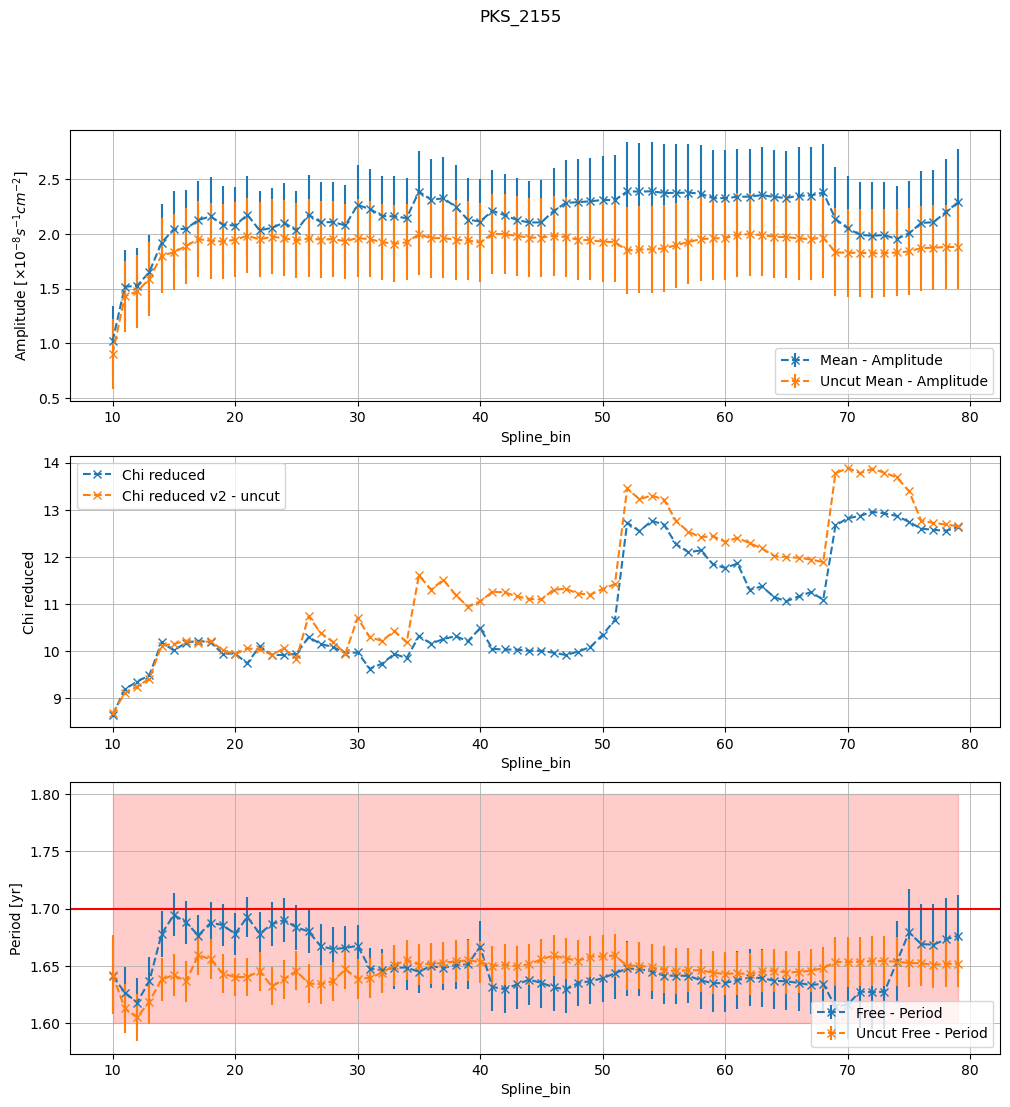

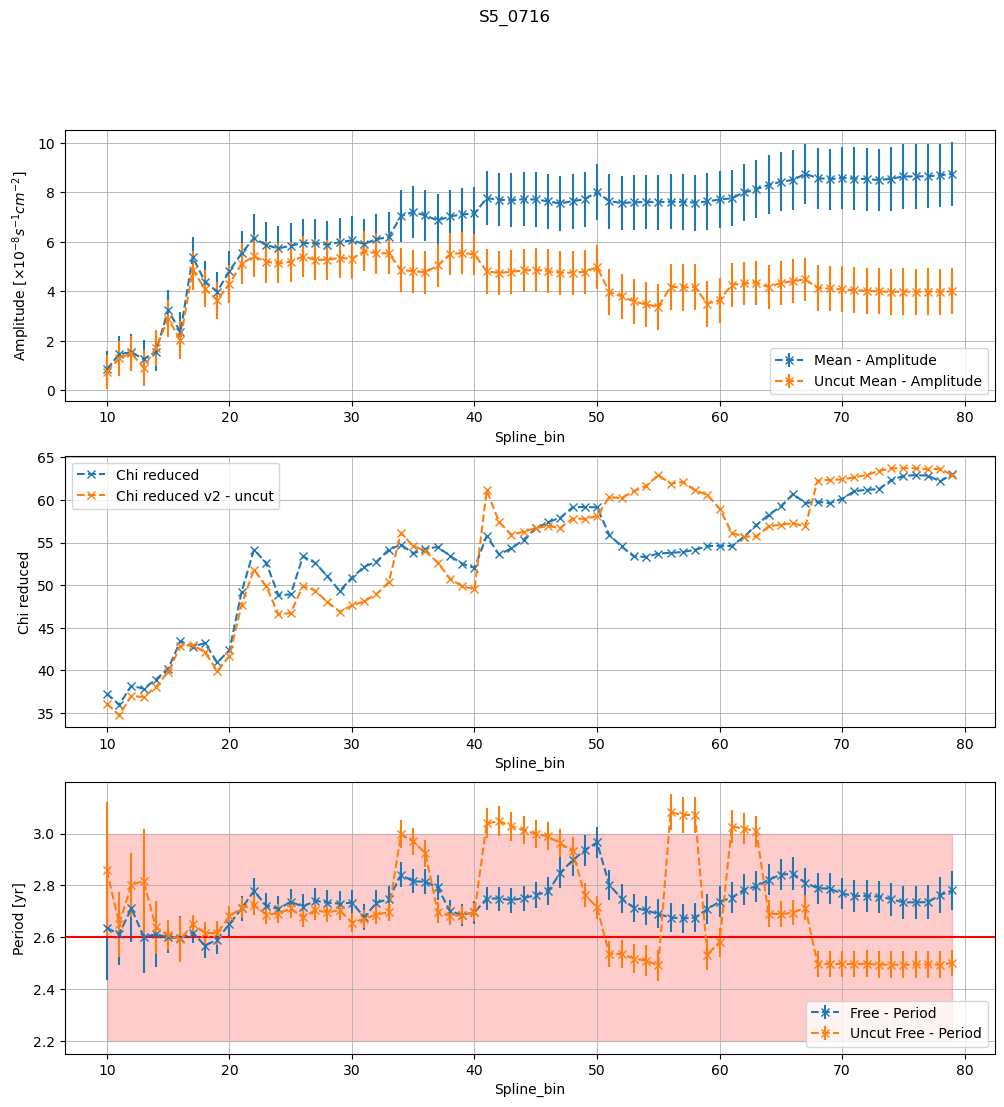

In [10]:
for k in data_out.keys():
    chired = data_out[k][0][3]
    chired_v2 = data_out[k][1][3]
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,12))
    fig.suptitle(k)
    
    ax1.errorbar(data_out[k][0][0], list(map(abs, data_out[k][0][1])), yerr=data_out[k][0][2], marker = 'x', linestyle = '--', 
                label='Mean - Amplitude')
    ax1.errorbar(data_out[k][1][0], list(map(abs, data_out[k][1][1])), yerr=data_out[k][1][2],marker = 'x', linestyle = '--', 
                label='Uncut Mean - Amplitude')
    ax1.set_ylabel(r'Amplitude [$\times 10^{-%s} s^{-1} cm^{-2}$]'% scaling_power)
    ax1.set_xlabel('Spline_bin')
    ax1.legend(loc='lower right')
    ax1.grid(linewidth=0.6)
    
    ax2.plot(data_out[k][0][0], data_out[k][0][3], 'x--', label='Chi reduced')
    ax2.plot(data_out[k][1][0], data_out[k][1][3], 'x--', label='Chi reduced v2 - uncut')
    ax2.set_ylabel('Chi reduced')
    ax2.set_xlabel('Spline_bin')
    ax2.legend()
    ax2.grid(linewidth=0.6)
    
    ax3.errorbar(data_out[k][0][0], list(map(abs, data_out[k][0][6])), yerr=data_out[k][0][7], marker = 'x', linestyle = '--', 
                label='Free - Period')
    ax3.errorbar(data_out[k][1][0], list(map(abs, data_out[k][1][6])), yerr=data_out[k][1][7],marker = 'x', linestyle = '--', 
                label='Uncut Free - Period')
    ax3.axhline(y=input_dict[k][5], color='r', linestyle='-')
    ax3.fill_between(data_out[k][0][0],input_dict[k][5]-input_dict[k][6],input_dict[k][5]+input_dict[k][6], color = 'r', alpha = 0.2)
    ax3.set_ylabel(r'Period [yr]')
    ax3.set_xlabel('Spline_bin')
    ax3.legend(loc='lower right')
    ax3.grid(linewidth=0.6)
    
    fig.savefig(standard_path+k+'/chi_reduced_free-Period.png',format='png',dpi=300)

# Amplitude festlegen und delta_F/F_mean berechnen

In [14]:
for k in data_out.keys():
    pos = input_dict[k][7]
    binning = data_out[k][0][0][pos-10]
    delta_F = data_out[k][0][1][pos-10]
    err_delta_F = data_out[k][0][2][pos-10]
    f_mean = data_out[k][0][4][pos-10]
    err_f_mean = data_out[k][0][5][pos-10]
    print(k, binning, delta_F, f_mean, delta_F/f_mean)
    print(f"{err_delta_F = }")
    print(f"{err_f_mean = }")
    print(f"{delta_F/f_mean = }")
    print(f"{np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = }")
    print()

PG_1553 29 1.034644344522813 4.147865617744407 0.24944017957010106
err_delta_F = 0.09900707775384901
err_f_mean = 0.04658962774059187
delta_F/f_mean = 0.24944017957010106
np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = 0.024033274437062924

OJ_014 39 -1.6686168863604156 2.6059567112784734 -0.6403087507703833
err_delta_F = 0.171635230871614
err_f_mean = 0.06390915447981614
delta_F/f_mean = -0.6403087507703833
np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = 0.06770876406732605

PKS_0454 24 7.2744711051485575 16.423683288285236 0.44292568100952895
err_delta_F = 1.0282733183419255
err_f_mean = 0.10977060320240134
delta_F/f_mean = 0.44292568100952895
np.sqrt((err_delta_F/f_mean)**2 + ((delta_F*err_f_mean)/f_mean**2)**2) = 0.0626791275881439

PKS_2155 21 -2.176199364789249 9.497578722496488 -0.22913201652486262
err_delta_F = 0.3539537515037353
err_f_mean = 0.07993072645457755
delta_F/f_mean = -0.22913201652486262
np.sqrt((err_delta_F/f_mean)*

## Eigene LCs